<IPython.core.display.Javascript object>


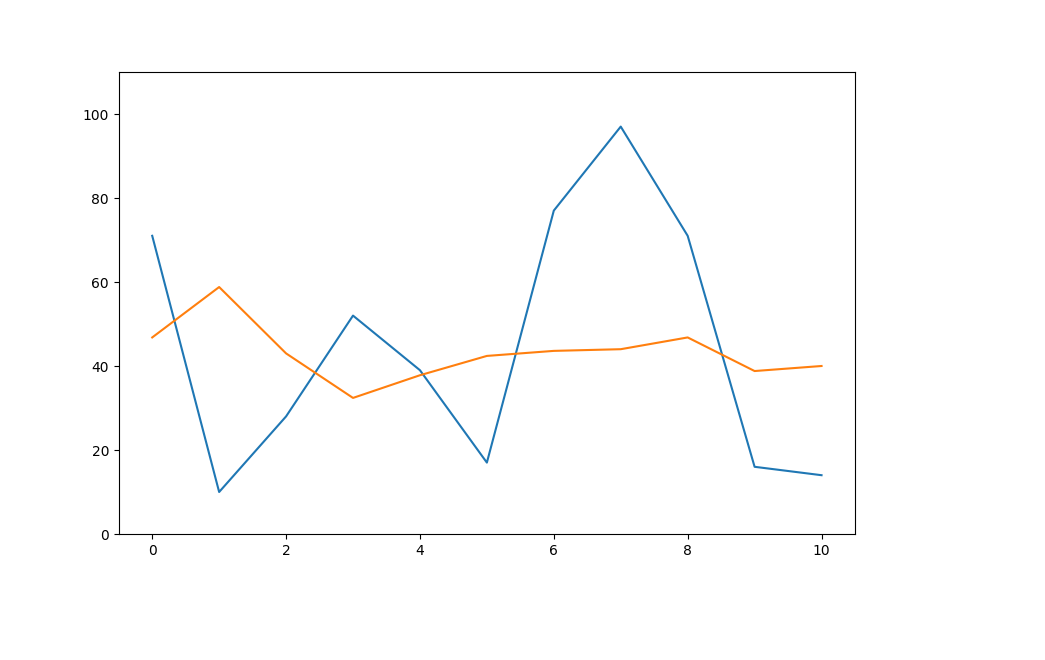

KeyboardInterrupt: 

In [2]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import statistics

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Week9-Topic'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax1):
    try:
        # container for x and y values
        x1, y1, y2 = [], [], []
        check = 0
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(', ')
            x1.append(data[0]) 
            y1.append(int(data[1]))
            if len(y1) > 5:
                # print (y1[:5])
                y2.append(statistics.mean(y1[:5]))
            else:
                y2.append(0)
                # print(y)
            # we start plotting only when we have 10 data points
            if len(y1) > 10:
                
                ax1.clear()
                ax1.plot(x1, y1)
                ax1.plot(x1, y2)
                ax1.set_xlabel('Creation Time')
                ax1.set_ylabel('Value')
                ax1.set_title('Creation Time Vs Value')
                ax1.set_ylim(0,110) 
                ax1.set_yticks([0,20,40,60,80,100])
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)
            
                fig.canvas.draw()
                x1.pop(0) # removing the item in the first position
                y1.pop(0)
                y2.pop(0)
                
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)
    
    